## Mask R-CNN - Loss Fucntions


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')
import mrcnn.model_mrcnn  as mrcnn_modellib
import mrcnn.model_fcn    as fcn_modellib
import mrcnn.visualize    as visualize
import mrcnn.new_shapes   as shapes
import mrcnn.utils        as utils

from datetime           import datetime   
from mrcnn.utils        import command_line_parser, Paths
from mrcnn.config       import Config
from mrcnn.dataset      import Dataset 
# from mrcnn.utils        import log, stack_tensors, stack_tensors_3d, write_stdout
from mrcnn.datagen      import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
from mrcnn.coco         import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
# from mrcnn.prep_notebook import mrcnn_newshape_train, prep_newshape_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

####  Pass input parameters to argparse

# args = parser.parse_args("--epochs 100 --steps_in_epoch 128  --last_epoch 1264 --batch_size 8  --lr 0.5               --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model init".split())
# input_parms = "--epochs 100 --steps_in_epoch 100  --last_epoch 1264 --batch_size 25 --lr 0.8 --val_steps 5 --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
# input_parms +=" --model     /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 "
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = "--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 1 --lr 0.00001 --val_steps 8 " 
# input_parms +="--mrcnn_logs_dir train_mrcnn_newshapes "
# input_parms +="--fcn_logs_dir   train_fcn8_newshapes "
input_parms +="--mrcnn_logs_dir train_mrcnn_coco "
input_parms +="--fcn_logs_dir   train_fcn8_coco "
input_parms +="--mrcnn_model    last "
input_parms +="--fcn_model      init "
input_parms +="--opt            adagrad "
input_parms +="--fcn_arch       fcn8 " 
input_parms +="--fcn_layers     all " 
input_parms +="--sysout        screen "
input_parms +="--new_log_folder    "
# input_parms +="--fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
print(input_parms)

args = parser.parse_args(input_parms.split())
# args = parser.parse_args()

##----------------------------------------------------------------------------------------------
## if debug is true set stdout destination to stringIO
##----------------------------------------------------------------------------------------------            
# debug = False
if args.sysout == 'FILE':
    sys.stdout = io.StringIO()

# print("    Dataset            : ", args.dataset)
# print("    Logs               : ", args.logs)
# print("    Limit              : ", args.limit)
print("    MRCNN Model        : ", args.mrcnn_model)
print("    FCN Model          : ", args.fcn_model)
print("    MRCNN Log Dir      : ", args.mrcnn_logs_dir)
print("    FCN Log Dir        : ", args.fcn_logs_dir)
print("    FCN Arch           : ", args.fcn_arch)
print("    FCN Log Dir        : ", args.fcn_layers)
print("    Last Epoch         : ", args.last_epoch)
print("    Epochs to run      : ", args.epochs)
print("    Steps in each epoch: ", args.steps_in_epoch)
print("    Validation steps   : ", args.val_steps)
print("    Batch Size         : ", args.batch_size)
print("    Optimizer          : ", args.opt)
print("    sysout             : ", args.sysout)
# print("    OS Platform        : ", syst)

##------------------------------------------------------------------------------------
## setup project directories
##   ROOT_DIR         : Root directory of the project 
##   MODEL_DIR        : Directory to save logs and trained model
##   COCO_MODEL_PATH  : Path to COCO trained weights
##---------------------------------------------------------------------------------
paths = Paths(fcn_training_folder = args.fcn_logs_dir, mrcnn_training_folder = args.mrcnn_logs_dir)
paths.display()

### Build Configuration Object

##------------------------------------------------------------------------------------
## Build configuration object 
##------------------------------------------------------------------------------------                          
mrcnn_config                    = CocoConfig()
# import mrcnn.new_shapes as new_shapes
# mrcnn_config = new_shapes.NewShapesConfig()

mrcnn_config.NAME               = 'mrcnn'              
mrcnn_config.TRAINING_PATH      = paths.MRCNN_TRAINING_PATH
mrcnn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
mrcnn_config.COCO_MODEL_PATH    = paths.COCO_MODEL_PATH   
mrcnn_config.RESNET_MODEL_PATH  = paths.RESNET_MODEL_PATH 
mrcnn_config.VGG16_MODEL_PATH   = paths.VGG16_MODEL_PATH  
mrcnn_config.COCO_CLASSES       = None 
mrcnn_config.DETECTION_PER_CLASS = 200
mrcnn_config.HEATMAP_SCALE_FACTOR = 4
mrcnn_config.BATCH_SIZE         = int(args.batch_size)                  # Batch size is 2 (# GPUs * images/GPU).
mrcnn_config.IMAGES_PER_GPU     = int(args.batch_size)                  # Must match BATCH_SIZE

mrcnn_config.STEPS_PER_EPOCH    = int(args.steps_in_epoch)
mrcnn_config.LEARNING_RATE      = float(args.lr)
mrcnn_config.EPOCHS_TO_RUN      = int(args.epochs)
mrcnn_config.FCN_INPUT_SHAPE    = mrcnn_config.IMAGE_SHAPE[0:2]
mrcnn_config.LAST_EPOCH_RAN     = int(args.last_epoch)

mrcnn_config.WEIGHT_DECAY       = 2.0e-4
mrcnn_config.VALIDATION_STEPS   = int(args.val_steps)
mrcnn_config.REDUCE_LR_FACTOR   = 0.5
mrcnn_config.REDUCE_LR_COOLDOWN = 30
mrcnn_config.REDUCE_LR_PATIENCE = 40
mrcnn_config.EARLY_STOP_PATIENCE= 80
mrcnn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
mrcnn_config.MIN_LR             = 1.0e-10
mrcnn_config.OPTIMIZER          = args.opt.upper()
mrcnn_config.NEW_LOG_FOLDER       = True
mrcnn_config.SYSOUT               = args.sysout
mrcnn_config.display() 


###  Build Model

from mrcnn.prep_notebook import mrcnn_coco_train
mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'training', mrcnn_config = mrcnn_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

--> Execution started at: 11-05-2018 @ 18:13:46
    Tensorflow Version: 1.8.0   Keras Version : 2.1.6 
--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 1 --lr 0.00001 --val_steps 8 --mrcnn_logs_dir train_mrcnn_coco --fcn_logs_dir   train_fcn8_coco --mrcnn_model    last --fcn_model      init --opt            adagrad --fcn_arch       fcn8 --fcn_layers     all --sysout        screen --new_log_folder    
    MRCNN Model        :  last
    FCN Model          :  init
    MRCNN Log Dir      :  train_mrcnn_coco
    FCN Log Dir        :  train_fcn8_coco
    FCN Arch           :  FCN8
    FCN Log Dir        :  ['all']
    Last Epoch         :  0
    Epochs to run      :  2
    Steps in each epoch:  32
    Validation steps   :  8
    Batch Size         :  1
    Optimizer          :  ADAGRAD
    sysout             :  SCREEN
>>> Initialize Paths
 Linx  Linux

Paths:
-------------------------
COCO_DAT

     pool_squeeze(Shared) output shape is :  (?, 200, 1024)
     mrcnn_class_logits   output shape is :  (?, 200, 81)
     mrcnn_class_probs    output shape is :  (?, 200, 81)
     mrcnn_bbox_fc        output shape is :  (?, 200, 324)
     mrcnn_bbox_fc        reshaped output :  (?, 200, 324)
     mrcnn_bbox           output shape is :  (?, 200, 81, 4)
--------------------------------
>>>  CHM Layer  
--------------------------------
  > CHMLayer Call()  3
    mrcnn_class.shape    : (?, 200, 81) (None, 200, 81)
    mrcnn_bbox.shape     : (?, 200, 81, 4) (None, 200, 81, 4)
    output_rois.shape    : (1, ?, ?) (None, 200, 4)

  > build_predictions()
    num_rois               :  200
    norm_input_rois.shape  :  <class 'tensorflow.python.framework.ops.Tensor'> (None, 200, 4)
    scale.shape            :  <class 'tensorflow.python.framework.ops.Tensor'> (4,) (4,)
    dup_scale.shape        :  <class 'tensorflow.python.framework.ops.Tensor'> (1, 200, 4) (1, 200, 4)

    mrcnn_class shape  

    loss      : (?, 200) Tensor("mrcnn_class_loss/Shape:0", shape=(2,), dtype=int32) KerasTensor:  False
    mean loss : () Tensor("mrcnn_class_loss/Shape_1:0", shape=(0,), dtype=int32) KerasTensor:  False
    reshaped mean loss : (1, 1) Tensor("mrcnn_class_loss/Shape_2:0", shape=(2,), dtype=int32) KerasTensor:  False

>>> mrcnn_class_loss_graph 
    target_class_ids  size : (?, 200)
    pred_class_logits size : (?, 200, 81)
    active_class_ids  size : (?, ?)
    loss      : (?, 200) Tensor("mrcnn_class_loss/Shape_3:0", shape=(2,), dtype=int32) KerasTensor:  False
    mean loss : () Tensor("mrcnn_class_loss/Shape_4:0", shape=(0,), dtype=int32) KerasTensor:  False
    reshaped mean loss : (1, 1) Tensor("mrcnn_class_loss/Shape_5:0", shape=(2,), dtype=int32) KerasTensor:  False

>>> mrcnn_bbox_loss_graph 
    target_class_ids  size : (1, ?)
    pred_bbox size         : (?, 200, 81, 4)
    target_bbox size       : (1, ?, ?)
    reshpaed pred_bbox size         : (?, 81, 4)
    reshaped tar

### Load saved weights

In [3]:
##------------------------------------------------------------------------------------
## Load Mask RCNN Model Weight file
##------------------------------------------------------------------------------------
# exclude_list = ["mrcnn_class_logits"]
#load_model(model, init_with = args.model)   
# exclude_list = ["mrcnn_class_logits", "mrcnn_bbox_fc"]
exclude_list = []
mrcnn_model.load_model_weights(init_with = 'last', exclude = exclude_list, verbose = 1)   

-----------------------------------------------
 Load Model with init parm: [ last ]
 Exclude layers: 
-----------------------------------------------
 ---> last
>>> find_last checkpoint in :  /home/kbardool/models/train_mrcnn_coco
    Key : > mrcnn <
    Dir names:  ['mrcnn20181105T1801', 'mrcnn20181105T1811', 'mrcnn20181105T1813', 'mrcnn20181011T1100']
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181105T1813
    Checkpoints:  []
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181105T1811
    Checkpoints:  []
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181105T1801
    Checkpoints:  []
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181011T1100
    Checkpoints:  ['mrcnn_0103.h5']
    find_last():   dir_name: /home/kbardool/models/train_mrcnn_coco/mrcnn20181011T1100
    find_  last(): checkpoint: /home/kbardool/models/train_mrcnn_coco/mrcnn20181011T1100/mrcnn_0103.h5
   Last file is : /home/kbardool/models/train_mrcnn_coco/mrcnn20181011

    0 bn4g_branch2b/gamma:0                hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   
    1 bn4g_branch2b/beta:0                 hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   
    2 bn4g_branch2b/moving_mean:0          hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   
    3 bn4g_branch2b/moving_variance:0      hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   

147 activation_29             Model Layer Name/Type : [['activation_29', 'Activation']] 

148 res4g_branch2c            Model Layer Name/Type : [['res4g_branch2c', 'Conv2D']] 
    0 res4g_branch2c/kernel:0              hdf5 Weights: (1, 1, 256, 1024)  		 Symbolic Wghts: (1, 1, 256, 1024)   
    1 res4g_branch2c/bias:0                hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   

149 bn4g_branch2c             Model Layer Name/Type : [['bn4g_branch2c', 'BatchNorm']] 
    0 bn4g_branch2c/gamma:0                hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   
    1 bn4g_branch2c/beta:0                 hdf5 We

270 add_26                    Model Layer Name/Type : [['add_26', 'Add']] 

271 res4s_out                 Model Layer Name/Type : [['res4s_out', 'Activation']] 

272 res4t_branch2a            Model Layer Name/Type : [['res4t_branch2a', 'Conv2D']] 
    0 res4t_branch2a/kernel:0              hdf5 Weights: (1, 1, 1024, 256)  		 Symbolic Wghts: (1, 1, 1024, 256)   
    1 res4t_branch2a/bias:0                hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   

273 bn4t_branch2a             Model Layer Name/Type : [['bn4t_branch2a', 'BatchNorm']] 
    0 bn4t_branch2a/gamma:0                hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   
    1 bn4t_branch2a/beta:0                 hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   
    2 bn4t_branch2a/moving_mean:0          hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   
    3 bn4t_branch2a/moving_variance:0      hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   

274 activation_54             Model Layer Name/Type : [['activation_54', 'Ac


371 mrcnn_class_conv2         Model Layer Name/Type : [['mrcnn_class_conv2', 'TimeDistributed']] 
    0 mrcnn_class_conv2/kernel:0           hdf5 Weights: (1, 1, 1024, 1024)  		 Symbolic Wghts: (1, 1, 1024, 1024)   
    1 mrcnn_class_conv2/bias:0             hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   

372 mrcnn_class_bn2           Model Layer Name/Type : [['mrcnn_class_bn2', 'TimeDistributed']] 
    0 mrcnn_class_bn2/gamma:0              hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   
    1 mrcnn_class_bn2/beta:0               hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   
    2 mrcnn_class_bn2/moving_mean:0        hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   
    3 mrcnn_class_bn2/moving_variance:0    hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   

373 activation_69             Model Layer Name/Type : [['activation_69', 'Activation']] 

374 pool_squeeze              Model Layer Name/Type : [['pool_squeeze', 'Lambda']] 

375 input_image_meta          

##  Build Training Datasets

### Build newshape datasets

In [ ]:
# del dataset_train, dataset_val, train_generator, val_generator
from mrcnn.prep_notebook import prep_newshape_dataset
dataset_train, train_generator = prep_newshape_dataset( mrcnn_config, 10000, generator=True)
dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_config,  2500, generator=True)

In [ ]:
print(type(dataset_train), type(train_generator))
print(len(dataset_train.image_info))
print(type(dataset_val), type(val_generator))
print(len(dataset_val.image_info))

### Build COCO datasets

In [4]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
from mrcnn.prep_notebook import prep_coco_dataset
dataset_train, train_generator = prep_coco_dataset(["train","val35k"], mrcnn_config, generator = True)

loading annotations into memory...
Done (t=12.31s)
creating index...
index created!
 image dir        :  /home/kbardool/MLDatasets/coco2014/train2014
 json_path_dir    :  /home/kbardool/MLDatasets/coco2014/annotations/instances_train2014.json
 number of images :  82081
loading annotations into memory...
Done (t=6.57s)
creating index...
index created!
 image dir        :  /home/kbardool/MLDatasets/coco2014/val2014
 json_path_dir    :  /home/kbardool/MLDatasets/coco2014/annotations/instances_valminusminival2014.json
 number of images :  35185


In [5]:
train_batch_x, train_batch_y = next(train_generator)

 batch size is : 1
 load image ud:  89243
Image meta  :  [89243   640   427     3     0   170  1024   853     1     1]
Classes     :  [ 1  1  1  1  2  8 10 10 10]
image_id    :  89243  Reference:  http://cocodataset.org/#explore?id=416523
 class_ids.shape[0]: 9 bbox.shape[0]: 9
Class Names :  ['person', 'person', 'person', 'person', 'bicycle', 'truck', 'traffic light', 'traffic light', 'traffic light']


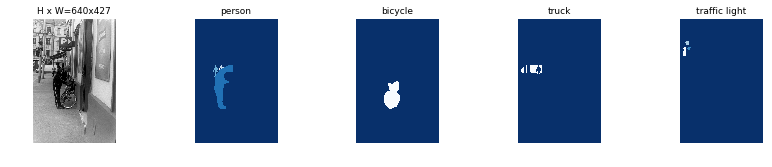

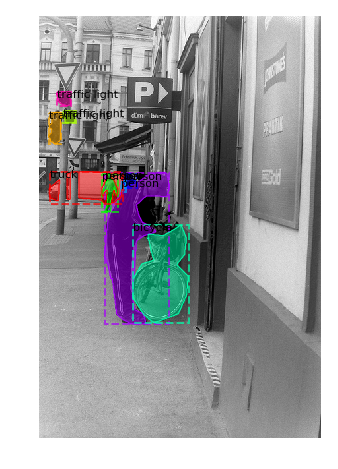

In [6]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 89243: Person, bicylce and traiffic lights
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 101623 (cake and forks), 41423 (elephant & people)
## 33477 Table, bowl, cup, sandwich, knife
# train_batch_x, train_batch_y = next(train_generator)
# IMAGE_LIST = [75040] 
IMAGE_LIST = [89243]
from mrcnn.datagen  import data_gen_simulate
# IMAGE_LIST = [75040, 89243]
# IMAGE_LIST = [27711]
# IMAGE_LIST = [29731]
train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_config, IMAGE_LIST )
 
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print('Image meta  : ', img_meta[img_idx,:10])
    print('Classes     : ', class_ids)
    print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
    print(' class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0])    
    
    class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
    print('Class Names : ', class_names)
    
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
    # Display image and instances
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))    

In [ ]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

##  Pass data thru MRCNN model

In [10]:
from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
mrcnn_model.layer_info()
# model.keras_model.outputs[0].name



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 index:  2    input name : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 index:  3    input name : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 index:  4    input name : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 index:  5    input name : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)


 Outputs:
 --------
 layer:  0    output name: rpn_class_loss/rpn_class_loss:0            Type: float32           Shape: (1, 1)
 layer:  1    output name: rpn_bbox_loss/rpn_bbox_loss:0              Type: float32           Shape: (1, 1)
 layer:  2    output name: mrcnn_class_loss/mrcnn_class_loss:0        Typ

In [12]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3,8,9,10], 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 261888, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

/* Outputs */
Output idx:  0    Layer:  0: (rpn_class_loss/rpn_class_loss:0         ) 	  Output shape: (1, 1)
Output idx:  1    Layer:  1: (rpn_bbox_loss/rpn_bbox_loss:0           ) 	  Output shape: (1, 1)
Output idx:  2    Layer:  2: (mrcnn_class_loss/mrcnn_class_loss:0     ) 	  Output shape: (1, 1)
Output idx:  3    Layer:  3: (mrcnn_bbox_loss/mrcnn_bbox_loss:0       ) 	  Output shape: (1, 1)
Output idx:  4    Layer:  8: (proposal_targets/target_class_ids:0     ) 	  Output shape: (1, 

In [13]:
print(len(model_output))

model_rpn_class_loss            = model_output[0]          # layer:  0   shape: (1, 1)
model_rpn_bbox_loss             = model_output[1]          # layer:  1   shape: (1, 1)
model_mrcnn_class_loss          = model_output[2]          # layer:  2   shape: (1, 1)
model_mrcnn_bbox_loss           = model_output[3]          # layer:  3   shape: (1, 1)
model_target_class_ids          = model_output[4]          # layer:  8   shape: (1, 200)
model_mrcnn_class_logits        = model_output[5]
model_active_class_ids          = model_output[6]
for i in model_output:
    print( i.shape)

7
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 200)
(1, 200, 81)
(1, 81)


In [15]:
model_active_class_ids
print(model_rpn_bbox_loss, model_rpn_class_loss)
print(model_mrcnn_bbox_loss, model_mrcnn_class_loss)

[[0.1711]] [[0.0125]]
[[0.1991]] [[0.4882]]


In [ ]:
input_image      =  train_batch_x[0]
input_image_meta =  train_batch_x[1]
input_rpn_match  =  train_batch_x[2]
input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes    = train_batch_x[5]
input_gt_masks     = train_batch_x[6]
print(' Input image shape is :', input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

# gt_masks   =  train_batch_x[6]
print(' input_rpn_match    ', input_rpn_match.shape)
print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids ', input_gt_class_ids.shape)
print(' input_gt_bboxes    ', input_gt_bboxes.shape)
print(' input_normlzd_gt_bboxes    ', input_normlzd_gt_bboxes.shape)


### Review values  

####  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=120, suppress=True)
img = 1
print('input_gt_class_ids')
print(input_gt_class_ids.shape)
print(input_gt_class_ids)


print('input_gt_bboxes')
print(input_gt_bboxes.shape)
print(input_gt_bboxes[img,:5]/[128,128,128,128])

print(target_class_ids.shape)
print(target_class_ids)
# print(input_gt_class_ids[0])

print(' roi_gt_bboxes')
print(roi_gt_boxes.shape)
print(roi_gt_boxes[img, :20])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' output_rois')
# print(output_rois.shape)
# print(output_rois[img,:15] * [128, 128,128,128])


# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:15] * [128, 128,128,128])

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype)
# print(pred_heatmap_scores[img,:,:10])

# print(' FCN Scores')
# print(fcn_scores.dtype)
# print(fcn_scores[img,:,:10, 4:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 


####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in range(5):
    print('Image ', img , ' ------------')
    print(output_rois[img])


####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_heatmap_scores[img,k])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_tensor shape is ', gt_tensor.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_tensor[img,k])


####  Display for visual check - `pred_heatmap_scores` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)

# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_score shape is ', pred_heatmap_scores.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_heatmap_scores[img,k])


####  Display for visual check - `gt_heatmap_scores` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('gt_heatmap_score shape is ', gt_heatmap_scores.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])


####  Display for visual check - `fcn_heatmap_scores` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=4)
# print('scatter shape is ', pred_scatt.get_shape())
print('fcn_heatmap_score shape is ', fcn_heatmap_scores.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(fcn_heatmap_scores[img,k,:,4:])


####  Display for visual check - `gt_heatmap_scores`  and `fcn_heatmap_scores` 

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())

img = 0
for i in [1,2,3]:
    for j in range(32):
        print('Image ', img , '/ Class ',i,' ------------')

        print(gt_heatmap_scores[img,i,j])
        print(pred_heatmap_scores[img,i,j])
        print(fcn_heatmap_scores[img,i,j,[0,1,2,3,4,5,11,12,13,14,15]])

### FCN Losses

In [ ]:
def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typicallly: [N, 4], but could be any shape.
    """
    diff = KB.abs(y_true - y_pred)
    less_than_one = KB.cast(KB.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


In [ ]:
##--------------------------------------------------------------------------
## setup input values
input_target = tf.identity(gt_heatmap_scores)
input_pred   = tf.identity(fcn_scores)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
sess = KB.get_session()
config = model.config
names = ['Dev']
##--------------------------------------------------------------------------


##-----------------------------------------------------------------------
##  FCN loss
##-----------------------------------------------------------------------    
# def fcn_norm_loss_graph(input_target,  input_pred):
with sess.as_default():
    '''
    Generate Loss based on Normalized score in PRED_HEATMAP_SCORES and FCN_HEATMAP_SCORES 
    
    Inputs:            
    gt_heatmap_scores   [batch, num_classes, num_rois, 11 ] --> column 9 contains normalized score.
    pred_heatmap:       [batch, num_classes, num_rois, 16 ] --> column 14 contains normalized score
    '''
    pred_scores   = input_pred[...,14]
    target_scores = input_target[...,9]
    # Reshape for simplicity. Merge first two dimensions into one.
    print('\n>>> fcn_norm_loss_graph ' )
    print('    target_scores shape :', target_scores.shape)
    print('    pred_scores   shape :', pred_scores.shape)    

    target_scores1 = KB.reshape(target_scores, (-1,1))
    print('    target_scores1 shape :', target_scores1.get_shape(), KB.int_shape(target_scores1))        
    pred_scores1   = KB.reshape(pred_scores  , (-1,1))
    print('    pred_scores1  shape :', pred_scores1.get_shape())        

#     # Compute binary cross entropy. If no positive ROIs, then return 0.
#     # shape: [batch, roi, num_classes]
#     # Smooth-L1 Loss
    loss        = KB.switch(tf.size(target_scores1) > 0,
                    smooth_l1_loss(y_true=target_scores1, y_pred=pred_scores1),
                    tf.constant(0.0))
    loss        = KB.mean(loss)
    loss        = tf.reshape(loss, [1, 1], name = 'fcn_normalized_loss')
    print('    loss type is :', type(loss))
    return loss
     

###  Softmax Sparse Cross Entropy Ignoring Last Label -- Used in Keras FCN

In [ ]:
import keras.backend as K 

y_pred = tf.placeholder(dtype=tf.float32, shape=(16,320,320,20))
y_true = tf.placeholder(dtype=tf.float32, shape=(16,320,320,1))
print(K.int_shape(y_pred), K.int_shape(y_true))
y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
print(K.int_shape(y_pred))
log_softmax = tf.nn.log_softmax(y_pred)
print(K.int_shape(log_softmax)) 

y_true = K.flatten(y_true)
print(K.int_shape(y_true))

y_true = K.one_hot(tf.to_int32(y_true), K.int_shape(y_pred)[-1]+1)
print(K.int_shape(y_true))

unpacked = tf.unstack(y_true, axis=-1)
print(len(unpacked), unpacked[0].shape)

y_true = tf.stack(unpacked[:-1], axis=-1)
print(K.int_shape(y_true))


cross_entropy = -K.sum(y_true * log_softmax, axis=1)
print(K.int_shape(cross_entropy))

cross_entropy_mean = K.mean(cross_entropy)
print(K.int_shape(cross_entropy_mean))




# import keras.backend as K
# print(K.int_shape(bef_pos)[-1])
# unpacked  = K.flatten(test)
# unpacked.shape

###  Calculate FCN bbox loss

###  Calculate FCN Norm loss

###  Calculate FCN bbox loss

###  Calculate FCN bbox loss

In [ ]:
sess = KB.get_session()
target_bbox_deltas = gt_deltas 
from mrcnn.loss import smooth_l1_loss

In [ ]:
def fcn_bbox_loss_graph(target_bbox_deltas, target_class_ids, fcn_bbox_deltas):
    print('\n>>> fcn_bbox_loss_graph ' )
    print('    target_class_ids  :', target_class_ids.shape)
    print('    fcn_bbox_deltas   :', fcn_bbox_deltas.shape)
    print('    target_bbox_deltas    :', target_bbox_deltas.shape)    

    ## Reshape to merge batch and roi dimensions for simplicity.
    class_array   = KB.reshape(target_bbox_deltas[...,-2]  , (-1, 1))
    tgt_bbox      = KB.reshape(target_bbox_deltas[...,:-2] , (-1, 4))
    pred_bbox     = KB.reshape(fcn_bbox_deltas, (-1, 4))
    print('    reshaped class_array            :', class_array.shape)
    print('    reshaped pred_bbox size         :', pred_bbox.shape)
    print('    reshaped target_bbox size       :', tgt_bbox.shape)    

    ## Only positive ROIs contribute to the loss. And only the right 
    ## class_id of each ROI. Get their indicies.

    pos_ix = tf.where(target_bbox_deltas[...,-2] > 0)

    ## Gather the deltas (predicted and true) that contribute to loss

    # IMPORTANT: THE :-2 IS TO PREVENT ADDITIONAL ELEMENTS FROM BEING COPIED
    y_true = tf.gather_nd(target_bbox_deltas[...,:-2], pos_ix)
    y_pred = tf.gather_nd(fcn_bbox_deltas, pos_ix)
    # print(y_pred.eval(session=sess))
    # print(tf.shape(y_pred).eval(session=sess), tf.shape(y_true).eval(session=sess))    
    print('    y_true shape:', y_true.get_shape())
    print('    y_pred shape:', y_pred.get_shape())


    ## Smooth-L1 Loss
    loss        = KB.switch(tf.size(y_true) > 0,
                    smooth_l1_loss(y_true=y_true, y_pred=y_pred),
                    tf.constant(0.0))
    loss        = KB.mean(loss)
    loss        = KB.reshape(loss, [1, 1])
    return loss

In [ ]:
loss  = fcn_bbox_loss_graph(target_bbox_deltas, target_class_ids, fcn_bbox_deltas)
print(loss.eval(session=sess))

In [ ]:
input_tgt_bbox_deltas = gt_deltas
input_pred_bbox_deltas = fcn_bbox_deltas
input_target_class_ids = target_class_ids
print(input_target_class_ids.shape)
print(input_target_class_ids)
print(input_tgt_bbox_deltas.shape)
# print(input_tgt_bbox_deltas[...,-2])
print(input_tgt_bbox_deltas[0,1,0:10])
class_array = input_tgt_bbox_deltas[...,-2]
print('class array: ', class_array.shape )
print(class_array[0] )
print(input_tgt_bbox_deltas[0])

In [ ]:
sess = KB.get_session()
print('\n>>> fcn_bbox_loss_graph ' )
print('    target_class_ids  :', input_target_class_ids.shape)
print('    fcn_bbox_deltas   :', input_pred_bbox_deltas.shape)
print('    gt_bbox_deltas    :', input_tgt_bbox_deltas.shape)    
# class_array = input_tgt_bbox_deltas[...,-2] 
print('    class-array       :', class_array.shape )
 
cls_arr       = KB.reshape(input_tgt_bbox_deltas[...,-2]  , (-1, 1))
tgt_bbox      = KB.reshape(input_tgt_bbox_deltas[...,:-2] , (-1, 4))
pred_bbox     = KB.reshape(input_pred_bbox_deltas, (-1, 4))
print('    reshaped class_array            :', cls_arr.shape)
print('    reshaped pred_bbox size         :', pred_bbox.shape)
print('    reshaped target_bbox size       :', tgt_bbox.shape)    
print(cls_arr.eval(session = sess))

In [ ]:
# pos_ix = tf.where(input_target_class_ids > 0)
# print(pos_ix.eval(session=sess))
# pos_roi_cls_ids = tf.gather_nd(input_target_class_ids, pos_ix)
# print(pos_roi_cls_ids.eval(session=sess))
# pos_roi_cls_ids = tf.expand_dims(pos_roi_cls_ids, axis = -1)
# print(tf.shape(pos_roi_cls_ids).eval(session=sess))
# ind = tf.concat([tf.to_int32(pos_ix), pos_roi_cls_ids], axis=-1)
# print(ind.eval(session=sess))
# tst_ix = tf.where(cls_arr > 0)
# print(tst_ix.eval(session=sess))

pos_ix = tf.where(input_tgt_bbox_deltas[...,-2] > 0)
print(pos_ix.eval(session=sess))
tgt_pos_cls_deltas = tf.gather_nd(input_tgt_bbox_deltas[...,:-2], pos_ix)
print(tgt_pos_cls_deltas.eval(session=sess))
pred_pos_cls_deltas = tf.gather_nd(input_pred_bbox_deltas, pos_ix)
print(pred_pos_cls_deltas.eval(session=sess))
print(tf.shape(pred_pos_cls_deltas).eval(session=sess), tf.shape(tgt_pos_cls_deltas).eval(session=sess))
# pos_roi_cls_ids = tf.expand_dims(pos_roi_cls_ids, axis = -1)
# print(tf.shape(pos_roi_cls_ids).eval(session=sess))
# ind = tf.concat([tf.to_int32(pos_ix), pos_roi_cls_ids], axis=-1)
# print(ind.eval(session=sess))


In [ ]:
print(input_pred_bbox_deltas.shape)

In [ ]:
# # Reshape to merge batch and roi dimensions for simplicity.
# tgt_class_ids = KB.reshape(target_class_ids, (-1,))
pred_shape = KB.int_shape(pred_bbox_deltas)
tgt_shape = KB.int_shape(tgt_bbox_deltas)
print('    transposed fcn_bbox_deltas   :', pred_shape)
print('    transposed gt_bbox_deltas    :', tgt_shape)    

tgt_bbox      = KB.reshape(tgt_bbox_deltas, (tgt_shape[0],  -1))
pred_bbox     = KB.reshape(pred_bbox_deltas   , (pred_shape[0] ,  -1))
print('    pred_bbox size         :', pred_bbox.shape)
print('    target_bbox size       :', tgt_bbox.shape)    

# # Only positive ROIs contribute to the loss. And only
# # the right class_id of each ROI. Get their indicies.
print(target_class_ids)
positive_roi_ix        = tf.where(target_class_ids > 0)[:,0] 
print(positive_roi_ix.eval(session=sess))
positive_roi_class_ids = tf.cast( tf.gather(target_class_ids, positive_roi_ix), tf.int64)
print(positive_roi_class_ids.eval(session=sess))
# indices                = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)

# # Gather the deltas (predicted and true) that contribute to loss
# target_bbox = tf.gather(gt_bbox_deltas, positive_roi_ix)
# pred_bbox   = tf.gather_nd(fcn_bbox_deltas, indices)
# print('    pred_bbox size         :', pred_bbox.shape)
# print('    target_bbox size       :', target_bbox.shape)    

# # Smooth-L1 Loss
# loss        = KB.switch(tf.size(target_bbox) > 0,
                # smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
                # tf.constant(0.0))
loss        = KB.constant(0.0)                    
loss        = KB.mean(loss)
loss        = KB.reshape(loss, [1, 1])
# return loss

### Calculate  mrcnn_bbox_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss
target_class_ids   = model_output[5]
target_bbox        = model_output[6]
mrcnn_bbox          = model_output[10] 

# target_bbox      = layers_out[2][0:1]
# mrcnn_class        = model_output[9]
# mrcnn_bbox       = layers_out[10][0:1]
mrcnn_class_ids  = np.argmax(model_output[9],axis = -1)     # mrcnn_class_ids
print('target_class_ids ', target_class_ids.shape)
print(target_class_ids[0])
print('target_bbox: ',target_bbox.shape)
print(target_bbox[0])
print('mrcnn_bbox : ',mrcnn_bbox.shape)
print(mrcnn_bbox[0])


In [ ]:
print('target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
# print(' class with max probability', mrcnn_class_ids.shape)
# print(mrcnn_class_ids)
print('target_bboxes shape', target_bbox.shape)
# print(target_bbox)  # tgt_bounding boxes
print('mrcnn_bboxes shape',mrcnn_bbox.shape)
# print(mrcnn_bbox)  #mrcnn_bboxes
pred_bbox = mrcnn_bbox

In [ ]:
# calc mrcnn_bbox_loss
target_class_ids = K.reshape(target_class_ids, (-1,))
print('target_class_ids shape: ', target_class_ids.shape)
print(target_class_ids.eval(session=sess))

target_bbox      = K.reshape(target_bbox, (-1, 4))
print('target_bbox: ', target_bbox.shape)

pred_bbox        = K.reshape(pred_bbox, (-1, pred_bbox.shape[2], 4))
print('pred_bbox : ', pred_bbox.shape)

In [ ]:
# test_ix        = tf.where(target_class_ids > 0)
# print('test_ix',test_ix.shape)
# print(test_ix.eval(session=sess))

positive_roi_ix        = tf.where(target_class_ids > 0)[:, 0]
print('postivie roi ix')
print(positive_roi_ix.eval(session=sess))

positive_roi_class_ids = tf.cast( tf.gather(target_class_ids, positive_roi_ix), tf.int64)
print('postivie roi class_ids')
print(positive_roi_class_ids.eval(session=sess))

indices                = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)
print('indices for gathering from mrcnn_bbox')
print(indices.eval(session=sess))


target_bbox2 = tf.gather(target_bbox, positive_roi_ix)
print('target bbox 2', tf.shape(target_bbox2).eval(session=sess))
print(target_bbox2.eval(session=sess))

pred_bbox2   = tf.gather_nd(pred_bbox, indices)
print('pred_bbox 2 ', tf.shape(pred_bbox2).eval(session=sess))
print(pred_bbox2.eval(session=sess))

In [ ]:
print('tf.size ',tf.size(target_bbox2).eval(session=sess))

diff = K.abs(target_bbox2 - pred_bbox2)
print(diff.eval(session=sess))

less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(less_than_one.eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print( (1-less_than_one).eval())



# loss        = K.switch(tf.size(target_bbox) > 0,
#                 smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
#                 tf.constant(0.0))
print(loss.eval())
sumloss = K.sum(loss)
print(sumloss.eval())
print((sumloss/40).eval())
meanloss        = K.mean(loss)
print(meanloss.eval())

###  Calculate mrcnn_class_loss

In [17]:
import keras.backend as KB
sess = KB.get_session()
# from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = tf.identity(model_target_class_ids)
pred_class_logits = tf.identity(model_mrcnn_class_logits)
active_class_ids  = tf.identity(model_active_class_ids)

In [69]:
# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print('    target_class_ids shape:', target_class_ids.shape)
# print(target_class_ids)  # tgt_class_ids
print('    class logits shape    :', pred_class_logits.shape)
# print(pred_class_logits)
print('    active_class_ids shape:', active_class_ids.shape)
# print(active_class_ids)  # tgt_bounding boxes
pred_class_ids = tf.argmax(pred_class_logits, axis=2)
print('    pred_class_ids        :', pred_class_ids.get_shape(), 'KerasTensor: ', KB.is_keras_tensor(pred_class_ids)) 
# print(pred_class_ids.eval())  #mrcnn_bboxes


pred_active = tf.gather(active_class_ids[0], pred_class_ids)
print('    pred_active           :', pred_active.get_shape(),  'KerasTensor: ', KB.is_keras_tensor(pred_active))  

loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target_class_ids, logits=pred_class_logits)
print('    loss                  :', loss.get_shape(), 'KerasTensor: ', KB.is_keras_tensor(loss))

loss_prod = loss * tf.to_float(pred_active)
print('    loss prod             :', loss_prod.get_shape(), 'KerasTensor: ', KB.is_keras_tensor(loss_prod))


    target_class_ids shape: (1, 200)
    class logits shape    : (1, 200, 81)
    active_class_ids shape: (1, 81)
    pred_class_ids        : (1, 200) KerasTensor:  False
    pred_active           : (1, 200) KerasTensor:  False
    loss                  : (1, 200) KerasTensor:  False
    loss prod             : (1, 200) KerasTensor:  False


In [70]:

with sess.as_default():
    r_pred_class_ids = pred_class_ids.eval()
    r_target_class_ids = target_class_ids.eval()
    r_pred_active      = pred_active.eval()
    r_loss = loss.eval()
    r_loss_prod = loss_prod.eval()

In [68]:
# dataset_train.source_class_ids[dataset_train.image_info[89243]["source"]]
# for i in dataset_train.image_info[89243]["annotations"]:
#     print(i['category_id'])
#     print(i)
print(dataset_train.num_classes)
pp = np.zeros([dataset_train.num_classes], dtype=np.int32)
print(pp)
print(class_ids)
pp[class_ids] = 1
print(pp)

81
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1  1  1  1  2  8 10 10 10]
[0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [74]:
print(model_active_class_ids)
print(r_pred_class_ids.shape, r_target_class_ids.shape, r_pred_active.shape, loss.shape)
print('pred_class_ids')
print(r_pred_class_ids)
print('target_class_ids')
print(r_target_class_ids)
print(r_loss)
print(r_pred_active[0])
print(r_loss_prod==r_loss)


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(1, 200) (1, 200) (1, 200) (1, 200)
pred_class_ids
[[ 1 10  2  1  0  2  1  0  0 10  2  2  2 10 10  0 10 10  1 10 10 10 10 10  0  0  1  0  1 10  0 10
   2  2  1  1  1 10  1  1  1  1  1  3  2  0  0  0  0  0  0 10  1  2  1  1 10  3 10 10 10  1  1 10
   1 10  0  0  0  0  0  0  0 10  0  0  0  0  0 10  0  0  0  0  0  0  0  0  1 10  0  0  0  0  0  1
   0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
   0  0  0  1  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]]
target_class_ids
[[ 1 10  2  2  8  2  1  1 10 10  2  2  2 10 10  8 10 10  1 10 10 

In [ ]:
 


print(tf.reduce_sum(loss).eval())
print(tf.reduce_sum(pred_active).eval())
loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
print(loss.eval())

###  Calculate mrcnn_mask_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids    = layers_out[1][0:3]
target_masks        = layers_out[3][0:3]
pred_masks          = layers_out[11][0:3]
# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print('    target_class_ids shape :', target_class_ids.shape)
print('    target_masks     shape :', target_masks.shape)
print('    pred_masks       shape :', pred_masks.shape)    


target_class_ids = K.reshape(target_class_ids, (-1,))
print('    target_class_ids shape :', target_class_ids.shape, '\n', target_class_ids.eval())

mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', mask_shape.shape, mask_shape.eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', pred_shape.shape, pred_shape.eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        


pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        

# Only positive ROIs contribute to the loss. And only
# the class specific mask of each ROI.
positive_ix        = tf.where(target_class_ids > 0)[:, 0]
positive_class_ids = tf.cast(tf.gather(target_class_ids, positive_ix), tf.int64)
indices            = tf.stack([positive_ix, positive_class_ids], axis=1)
print(indices.eval())



y_true = tf.gather(target_masks, positive_ix)
print('     y_true shape:', tf.shape(y_true).eval())
y_pred = tf.gather_nd(pred_masks, indices)
print('     y_pred shape:', tf.shape(y_pred).eval())

loss = K.switch(tf.size(y_true) > 0,
                K.binary_crossentropy(target=y_true, output=y_pred),
                tf.constant(0.0))
print(tf.shape(loss).eval())

loss = K.mean(loss)
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())

### Calculate a pixel loss on fcn_gaussian and gt_gaussian 

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss
pred_masks          = layers_out[12][0:3]   # fcn_predictions 
target_masks        = layers_out[19][0:3]   # gt_gaussians

print('    target_masks     shape :', tf.shape(target_masks).eval())
print('    pred_masks       shape :', tf.shape(pred_masks).eval())    

diff = K.abs(target_masks - pred_masks)
print(tf.shape(diff).eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
print('   less_than_one     shape :', tf.shape(less_than_one).eval(), K.sum(less_than_one).eval())

more_than_one = 1 - less_than_one
print('   more_than_one     shape :', tf.shape(more_than_one).eval(), K.sum(more_than_one).eval())
# loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)

loss = (less_than_one * 0.5 * diff**2) + (more_than_one * (diff - 0.5))
print(tf.shape(loss).eval())

# loss = K.switch(tf.size(y_true) > 0,
#                 K.binary_crossentropy(target=y_true, output=y_pred),
#                 tf.constant(0.0))
meanloss = K.mean(loss)
print(tf.shape(meanloss).eval())
print(meanloss.eval())
# loss = K.reshape(loss, [1, 1])
# print('     final loss shape:', loss.get_shape())
# return loss


mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', tf.shape(mask_shape).eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[1], mask_shape[2]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', tf.shape(pred_shape).eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[1], pred_shape[2]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())

# Permute predicted masks to [N, num_classes, height, width]
# diff = K.abs(target_masks - pred_masks)
# print(tf.shape(diff).eval())

# less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(tf.shape(less_than_one).eval())

# loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print(tf.shape(loss).eval())

# meanloss = K.mean(loss)
# print(tf.shape(meanloss).eval())
# print(meanloss.eval())

loss = K.switch(tf.size(target_masks) > 0,
                smooth_l1_loss(y_true=target_masks, y_pred=pred_masks),
                tf.constant(0.0))
loss = K.mean(loss)
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', loss.get_shape())
print(loss.eval())

In [ ]:
img  = 0
class_probs = layers_out[9][img]   # mrcnn_class
deltas      = layers_out[10][img]       # mrcnn_bbox

print(class_probs.shape)
print('class probabilities')
print(class_probs)
class_ids = np.argmax(layers_out[9][img],axis = 1)     # mrcnn_class_ids
print(' class with max probability')
print(class_ids)


# layers_out[10][2,0,3]
print('deltas.shape :', deltas.shape)
print(deltas[0:4])

deltas_specific = deltas[np.arange(32),class_ids]
print('deltas of max prob class: ', deltas_specific.shape)
print(deltas_specific[0:5])
output_rois = layers_out[0][img]*[128,128,128,128]
print('output_rois: ', output_rois.shape)
print(output_rois[0:])

refined_rois    = apply_box_deltas(output_rois, deltas_specific * config.BBOX_STD_DEV)
print('refined rois: ',refined_rois.shape)
print(refined_rois)

In [ ]:
img = 0
cls = 0
fcn_out = layers_out[12][img]
fcn_sum = np.sum(fcn_out, axis=(0,1))
print(fcn_sum)
for cls in range(4):
    print('min :', np.min(fcn_out[:,:,cls]), 'max :', np.max(fcn_out[:,:,cls]), )

In [ ]:
print(train_batch_x[4][2])
print(train_batch_x[5][2]/[128,128,128,128])